In [1]:
import numpy as np
import plotly.express as px

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from tqdm.notebook import trange

from joblib import Parallel, delayed

## Objective functions



In [2]:
def oneMax(chromosome):
    '''
    Returns the numbers of ones.
    Maximum: chromosome consisting only of 1s
    '''
    return sum(chromosome)

def deceptiveOneMax(chromosome):
    '''
    Returns the numbers of ones or length plus one in the case of 0s only.
    Maximum: chromosome consisting only of 0s
    '''
    chromosome_sum = sum(chromosome)
    return len(chromosome) + 1 if chromosome_sum == 0 else chromosome_sum

def kDeceptiveOneMax(chromosome, k):
    '''
    Returns the sum of ones plus bonus for every section of length k that consists only of 0s.
    Maximum: chromosome consisting only of 0s
    '''
    chromosome_sum = 0
    for section in range(len(chromosome)//k):
        part_sum = sum(chromosome[section*k:(section+1)*k])
        if part_sum == 0:
            chromosome_sum += k+1
        else:
            chromosome_sum += part_sum
    return chromosome_sum

name_to_objective = {
    "onemax": oneMax,
    "deceptiveonemax": deceptiveOneMax,
    "kdeceptiveonemax": kDeceptiveOneMax
}

## PBIL Algorithm

In [3]:
class PBIL:
    def __init__(self,
                 chromosome_length,
                 population_size,
                 learning_rate,
                 mutation_rate,
                 mutation_distortion_rate,
                 objective,
                 k=None,
                 name=None):
        self.chromosome_length = chromosome_length
        self.population_size = population_size
        self.learning_rate = learning_rate
        self.mutation_rate = mutation_rate
        self.mutation_distortion_rate = mutation_distortion_rate
        self.objective = name_to_objective[objective]
        if objective == 'kdeceptiveonemax':
            self.objective = lambda x: kDeceptiveOneMax(x, k)
        self.name = name

        self.probabilities = np.ones((self.chromosome_length,))*0.5
        self.resample_population()

        self.objective_values = []
        self.historical_probabilities = []

    def resample_population(self):
        population = np.random.random((self.population_size, self.chromosome_length))
        population = (population < self.probabilities).astype('int')
        self.population = population

    def evaluate_objective(self):
        self.objective_values.append(np.array([self.objective(chromosome.tolist())
                                            for chromosome in self.population]))
        self.historical_probabilities.append(self.probabilities.tolist())

    def evolve(self, epochs):
        for epoch in range(epochs):
            self.evaluate_objective()
            best_chromosome = self.population[self.objective_values[-1].argmax()]
            self.probabilities = self.probabilities*(1-self.learning_rate) + self.learning_rate*best_chromosome

            if np.random.rand() < self.mutation_rate:
                self.probabilities = self.probabilities*(1-self.mutation_distortion_rate) + self.mutation_distortion_rate*int(np.random.rand()<0.5)

            self.resample_population()
        self.evaluate_objective()

    def plot_evolution(self, backend='plt'):
        if backend == 'plotly':
            fig = make_subplots(rows=1, cols=2)
            for line, values in self.get_scores().items():
                fig.add_trace(
                    go.Scatter(y=values, mode='lines', name=line), row=1, col=1
                )
        
            for i, prob in enumerate(zip(*self.get_historical_probabilities())):
                fig.add_trace(
                    go.Scatter(y=prob, mode='lines', name=i), row=1, col=2
                )
    
            fig.update_layout(width=1200, height=600, title_text="PBIL Experiment")
            fig.show()
        else:

            # Create subplot with two plots
            fig, axs = plt.subplots(1, 2, figsize=(12, 6))
            
            # Plot line plot in first plot
            for line, values in self.get_scores().items():
                axs[0].plot(values, label=line)
            axs[0].set_title('Objective')
            axs[0].legend()
            
            # Plot scatter plot in second plot
            for i, prob in enumerate(zip(*self.get_historical_probabilities())):
                axs[1].plot(prob, label=str(i))
            axs[1].set_title('Probabilities')
            
            # Adjust spacing between plots
            plt.subplots_adjust(wspace=0.3)
            
            # Display plot
            plt.suptitle('PBIL Experiment')
            plt.show()

    def get_scores(self):
        return {
            f'best_score_{self.name}': [scores.max() for scores in self.objective_values],
            f'mean_score_{self.name}': [scores.mean() for scores in self.objective_values],
            f'worst_score_{self.name}': [scores.min() for scores in self.objective_values]
        }

    def get_historical_probabilities(self):
        return self.historical_probabilities


### d=100 OneMax

In [4]:
config_A = {"epochs": 1000, "chromosome_length": 100, "population_size": 125, "learning_rate": 0.01, "mutation_rate": 0.05, "mutation_distortion_rate": 0.01, "objective": "onemax"}

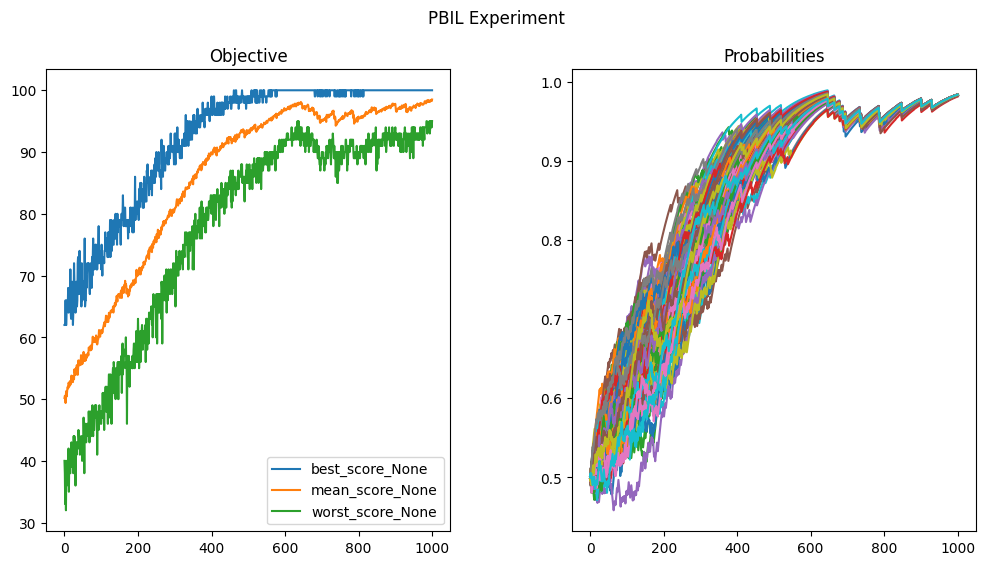

In [5]:
pbil = PBIL(**{key: value for key, value in config_A.items() if key != 'epochs'})
pbil.evolve(1000)
pbil.plot_evolution()

### d=1000 onemax

In [30]:
config_B = {"epochs": 1000, "chromosome_length": 1000, "population_size": 125, "learning_rate": 0.1, "mutation_rate": 0.1, "mutation_distortion_rate": 0.01, "objective": "onemax"}

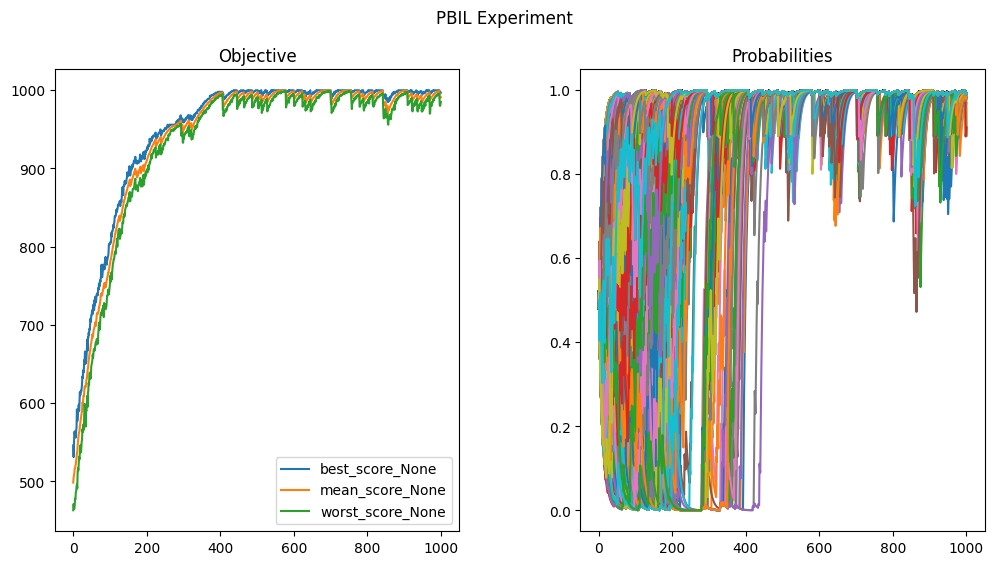

In [31]:
pbil = PBIL(**{key: value for key, value in config_B.items() if key != 'epochs'})
pbil.evolve(1000)
pbil.plot_evolution()

### d=100 deceptive onemax

In [9]:
config_C = {"epochs": 1000, "chromosome_length": 100, "population_size": 125, "learning_rate": 0.01, "mutation_rate": 0.05, "mutation_distortion_rate": 0.01, "objective": "deceptiveonemax"}

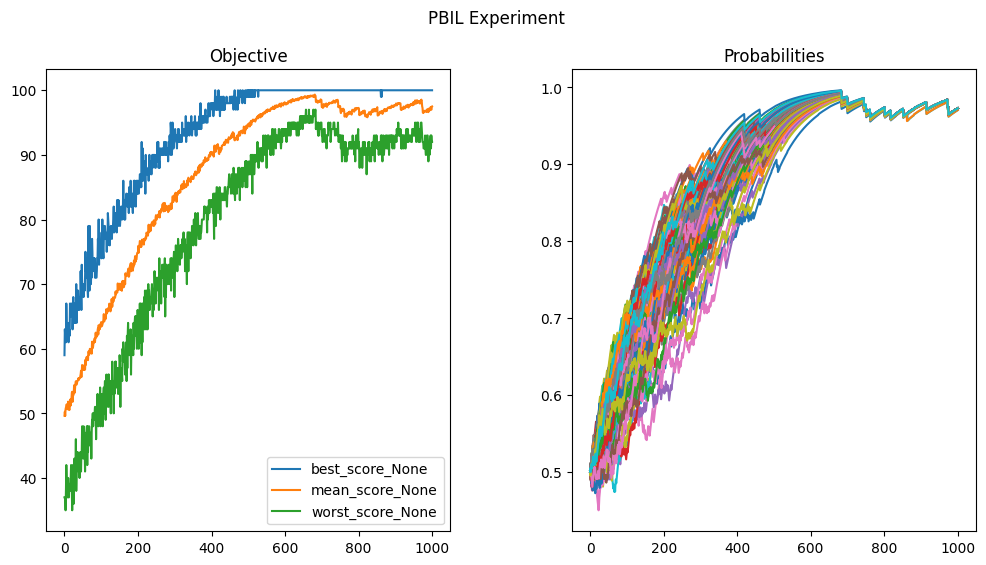

In [10]:
pbil = PBIL(**{key: value for key, value in config_C.items() if key != 'epochs'})
pbil.evolve(1000)
pbil.plot_evolution()

### d=1000 deceptive onemax

In [33]:
config_D = {"epochs": 1000, "chromosome_length": 1000, "population_size": 125, "learning_rate": 0.1, "mutation_rate": 0.1, "mutation_distortion_rate": 0.01, "objective": "deceptiveonemax"}

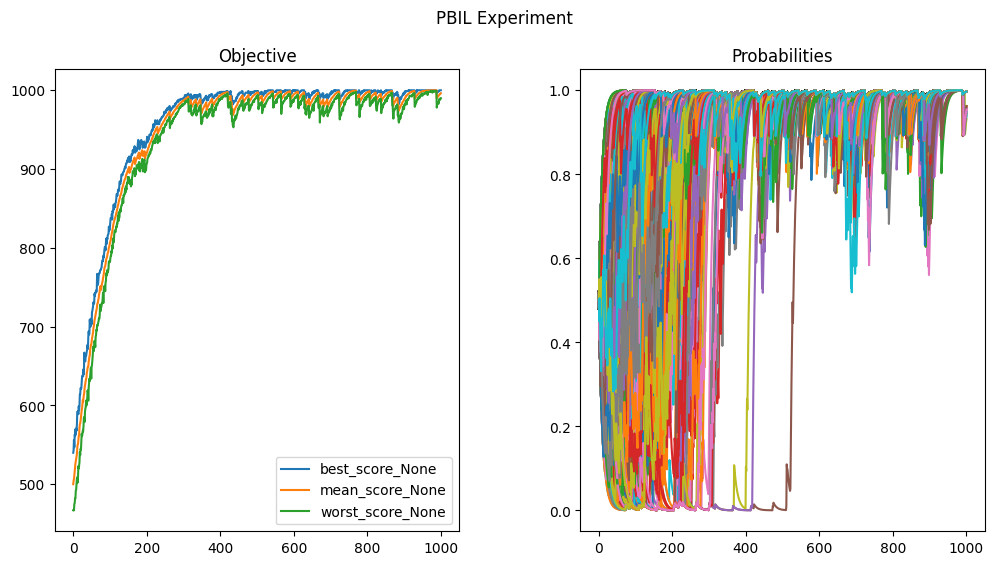

In [34]:
pbil = PBIL(**{key: value for key, value in config_D.items() if key != 'epochs'})
pbil.evolve(1000)
pbil.plot_evolution()

### d=100 k=10 deceptive onemax

In [67]:
config_E = {"epochs": 1000, "chromosome_length": 100, "population_size": 125, "learning_rate": 0.1, "mutation_rate": 0.1, "mutation_distortion_rate": 0.01, "objective": "kdeceptiveonemax", "k": 10}

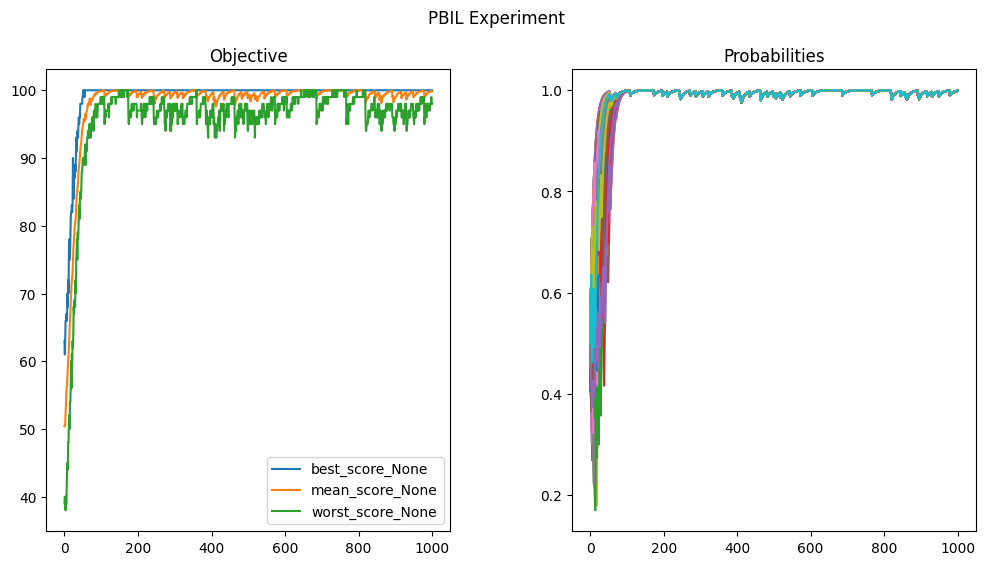

In [68]:
pbil = PBIL(**{key: value for key, value in config_E.items() if key != 'epochs'})
pbil.evolve(1000)
pbil.plot_evolution()

### d=1000 k=10 deceptive onemax

In [69]:
config_F = {"epochs": 1000, "chromosome_length": 1000, "population_size": 125, "learning_rate": 0.1, "mutation_rate": 0.1, "mutation_distortion_rate": 0.01, "objective": "kdeceptiveonemax", "k":10}

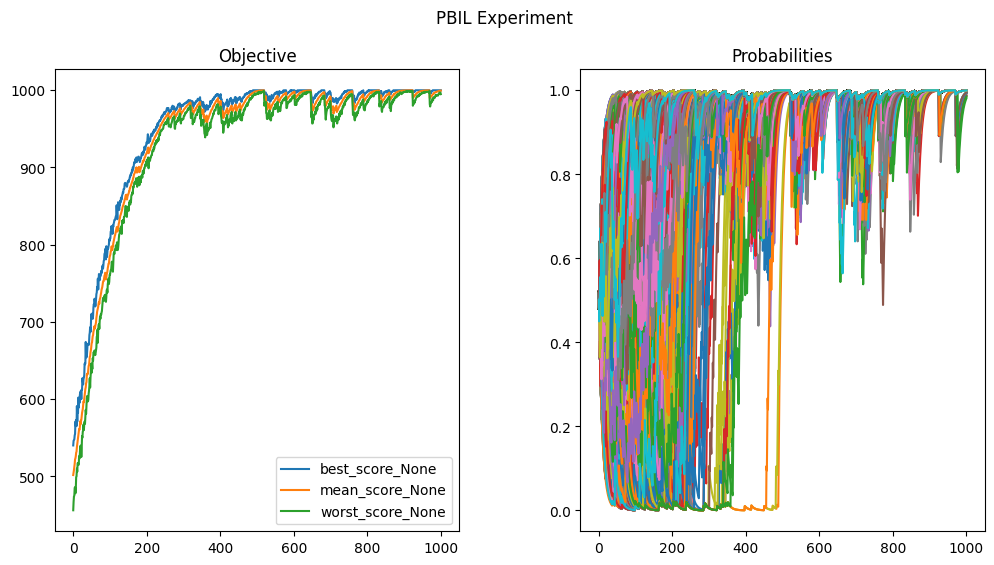

In [37]:
pbil = PBIL(**{key: value for key, value in config_F.items() if key != 'epochs'})
pbil.evolve(1000)
pbil.plot_evolution()

### d=100 k=5 deceptive onemax

In [76]:
config_G = {"epochs": 1000, "chromosome_length": 100, "population_size": 125, "learning_rate": 0.05, "mutation_rate": 0.25, "mutation_distortion_rate": 0.01, "objective": "kdeceptiveonemax", "k": 5}

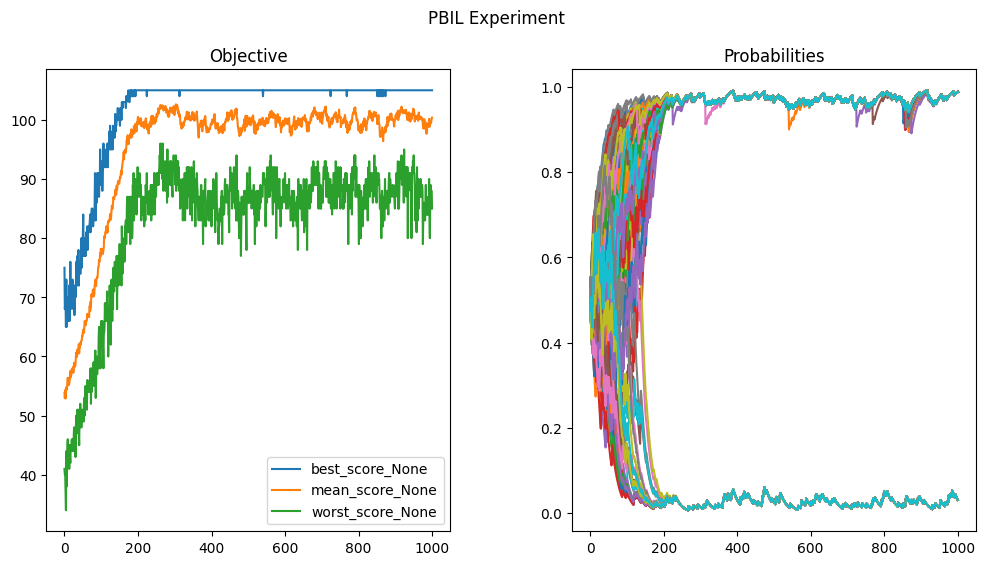

In [77]:
pbil = PBIL(**{key: value for key, value in config_G.items() if key != 'epochs'})
pbil.evolve(1000)
pbil.plot_evolution()

### d=1000 k=5 deceptive onemax

In [78]:
config_H = {"epochs": 1000, "chromosome_length": 1000, "population_size": 125, "learning_rate": 0.1, "mutation_rate": 0.1, "mutation_distortion_rate": 0.01, "objective": "kdeceptiveonemax", "k":5}

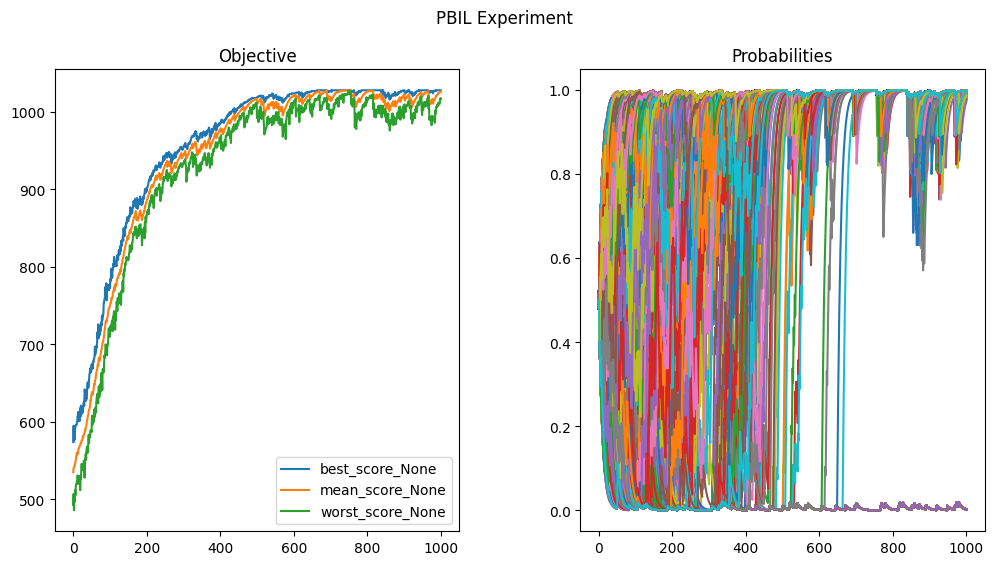

In [79]:
pbil = PBIL(**{key: value for key, value in config_H.items() if key != 'epochs'})
pbil.evolve(1000)
pbil.plot_evolution()

### d=1000 k=5 deceptive onemax long run

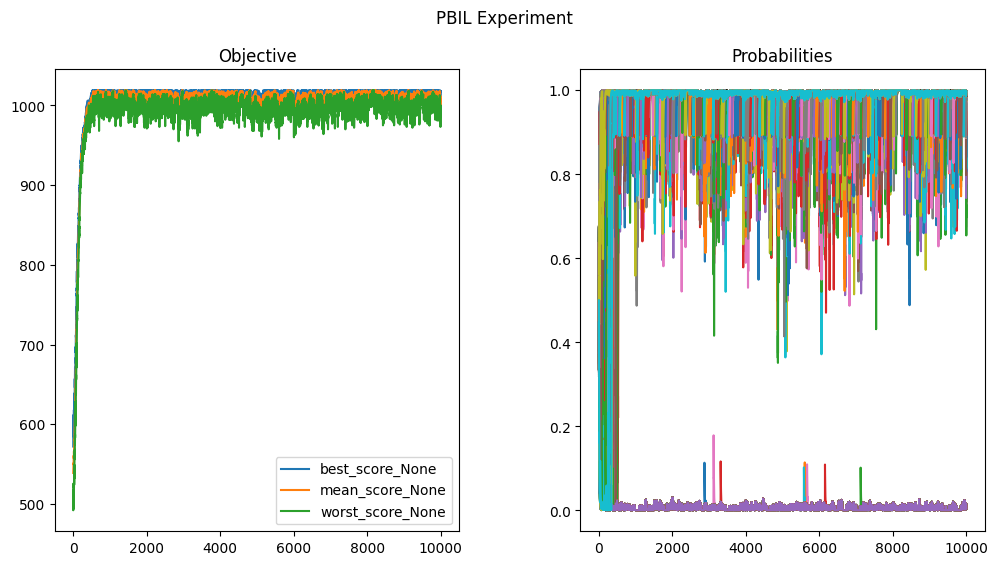

In [80]:
pbil = PBIL(**{key: value for key, value in config_H.items() if key != 'epochs'})
pbil.evolve(10000)
pbil.plot_evolution()

### d=100 k=2 deceptive onemax

In [81]:
config_I = {"epochs": 1000, "chromosome_length": 100, "population_size": 125, "learning_rate": 0.01, "mutation_rate": 0.05, "mutation_distortion_rate": 0.01, "objective": "kdeceptiveonemax", "k": 2}

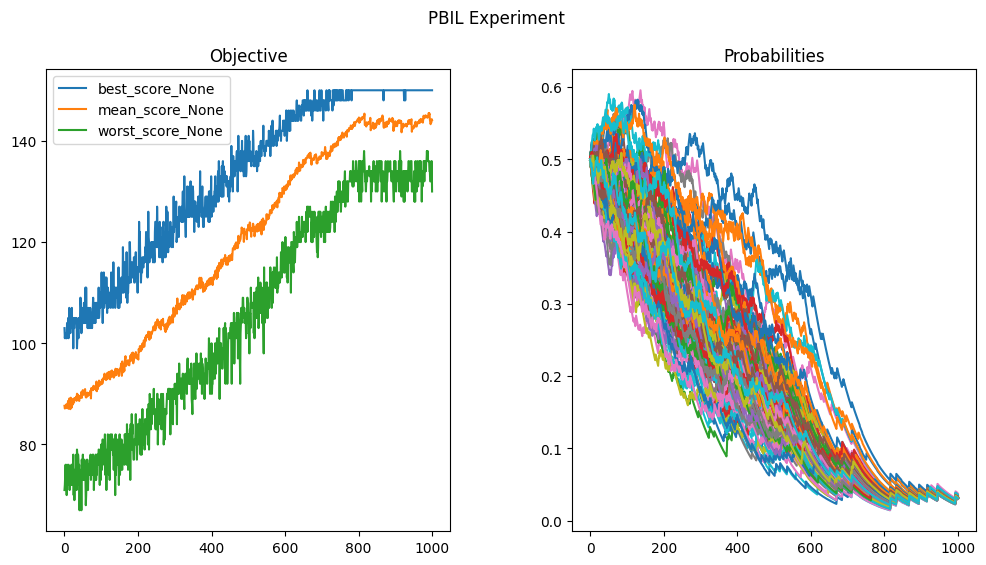

In [82]:
pbil = PBIL(**{key: value for key, value in config_I.items() if key != 'epochs'})
pbil.evolve(1000)
pbil.plot_evolution()

### d=1000 k=2 deceptive onemax

In [83]:
config_J = {"epochs": 1000, "chromosome_length": 1000, "population_size": 125, "learning_rate": 0.1, "mutation_rate": 0.1, "mutation_distortion_rate": 0.01, "objective": "kdeceptiveonemax", "k":2}

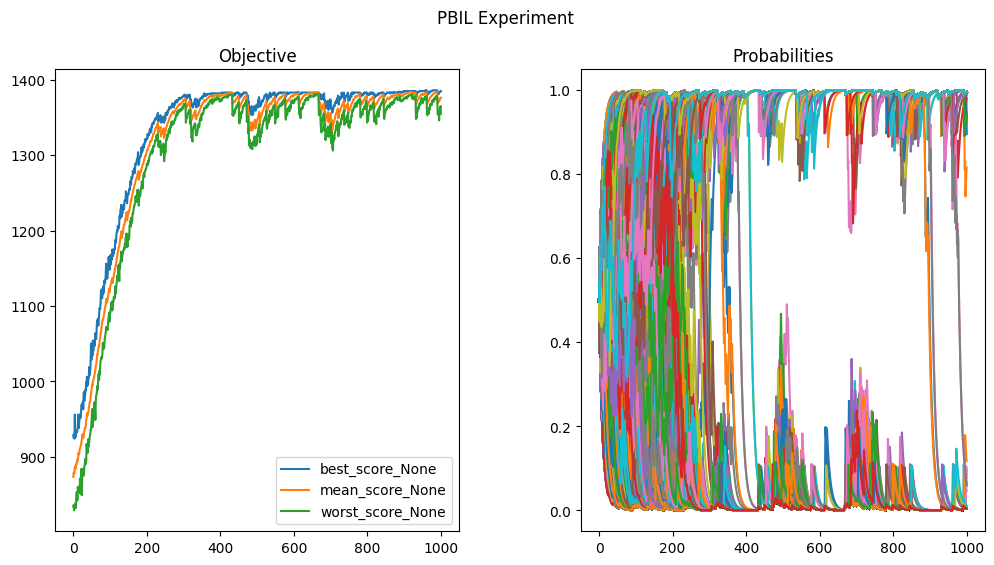

In [84]:
pbil = PBIL(**{key: value for key, value in config_J.items() if key != 'epochs'})
pbil.evolve(1000)
pbil.plot_evolution()

### d=1000 k=2 deceptive onemax long run

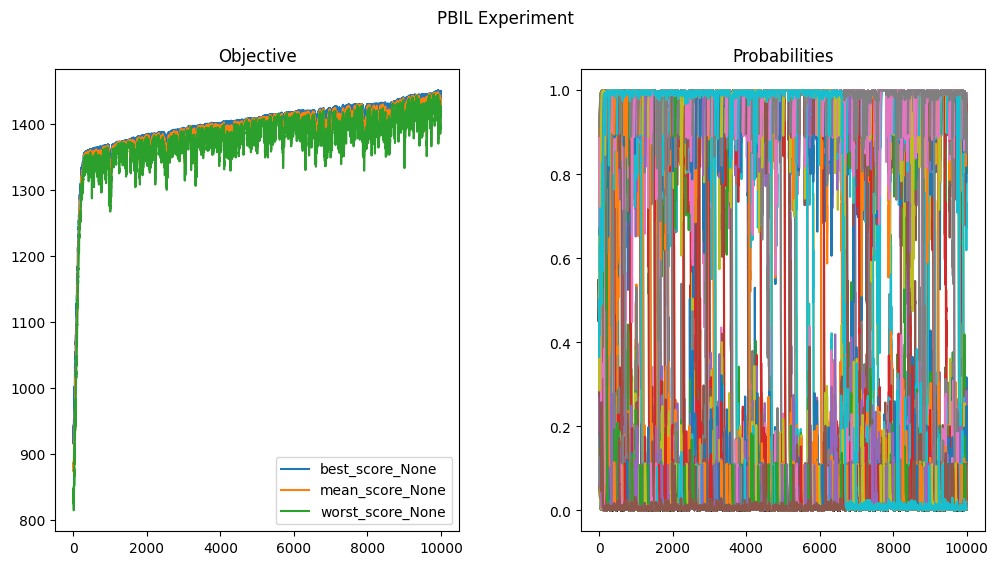

In [85]:
pbil = PBIL(**{key: value for key, value in config_J.items() if key != 'epochs'})
pbil.evolve(10000)
pbil.plot_evolution()

### d=1000 k=2 deceptive onemax very long run

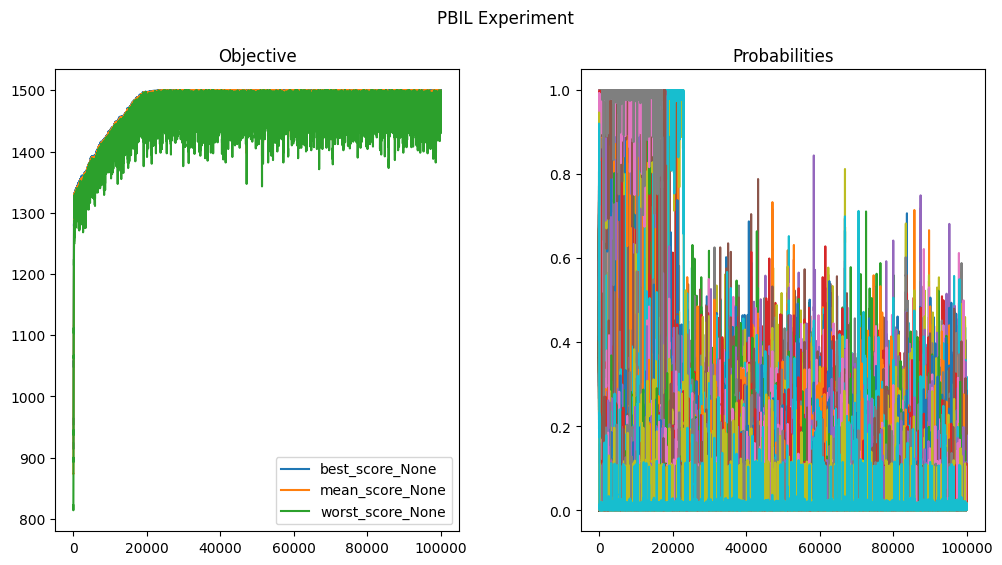

In [86]:
pbil = PBIL(**{key: value for key, value in config_J.items() if key != 'epochs'})
pbil.evolve(100000)
pbil.plot_evolution()